# Purpose: 
Generate a fire perimeter in GeoJSON based on the input pre and post flight images

In [1]:
import sys
from pathlib import Path

# Add the path to the utils folder to sys.path
utils_path = Path("/shared/Wildfire/Bety_wildfire_project/Bety_A_S_code/wildfire_HV_logratio/uavsar-main/python").resolve()
sys.path.append(str(utils_path))

import numpy as np
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from pathlib import Path
from rasterio.plot import show
# from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from process_utils import (preprocess_data, 
                           superpixel_segmentation,
                           get_superpixel_model_labels,get_model_labels,
                           convert_labels_to_gdf,
                           filter_by_area,
                           merge_geojson,
                           tv_denoise,)
from nd_utils import (get_superpixel_means_as_features,
                      get_superpixel_stds_as_features,get_superpixel_medians_as_features,
                      get_array_from_features)
# # from process_utils import (preprocess_data, 
#                            get_model_labels)
from rio_utils import (reproject_arr_to_match_profile)
from shapely.geometry import Polygon
from shapely.geometry import Point
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

In [2]:
def denoise(data, weight):
    mask = np.isnan(data)
    data[mask] = 9999
    data_tv = tv_denoise(data, weight)
    data_tv[mask] = np.nan

    return data_tv

---
## Load the images into arrays

**Parameter**:
- `tifs` (list): a list containing the paths to the preprocessed images
- `superpixel_labels_list` (list): a list containing the paths to the superpixel labels

In [3]:
def open_one(path):
    with rasterio.open(path) as ds:
        band = ds.read(1)
        profile = ds.profile
        transform = ds.transform
    return band, profile, transform

In [4]:
# Path to the folder with the preprocessed images
data_dir = Path("/shared/Wildfire/Bety_wildfire_project/Bety_A_S_code/wildfire_HV_logratio/data_output_HV_logratio")

tifs = sorted(list(data_dir.glob('./*before_imputed_*.tif')))
tifs

[PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_A_S_code/wildfire_HV_logratio/data_output_HV_logratio/before_imputed_hv_0_preprocessed_interpolated.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_A_S_code/wildfire_HV_logratio/data_output_HV_logratio/before_imputed_hv_1_preprocessed_interpolated.tif')]

---
Open the preprocessed images and load the superpixel segmentation corresponded to the pre- and post- fire.

- Let `hv_0` correspond to the pre-fire image and `hv_1` correspond to the post-fire image. 
- Let `profile` and `transform` correspond to the pre-fire image.
- Let `superpixel_labels` be the output of the segmentation

In [5]:
# open the tifs
bands_tv, profiles, transforms = zip(*map(open_one, tifs))
hv_0 = bands_tv[0]
hv_1 = bands_tv[1]
profile = profiles[0]
transform = transforms[0]

In [6]:
hv_0 = denoise(hv_0,5)
hv_1 = denoise(hv_1,5)

---
This is the preprocessed raster image we will work with to extract the fire perimeter

In [7]:
# compute log ratio and filter out the vegetation gain by setting to no change.
log_ratio = 10*np.log10(hv_0/hv_1)

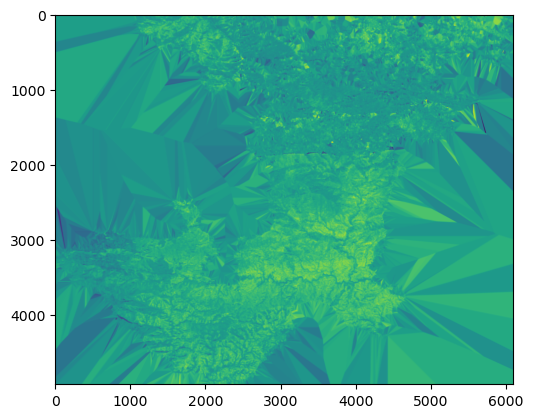

In [8]:
plt.imshow(log_ratio)

In [9]:
# Load if we have performed segmentation previously
superpixel_labels = np.load("/shared/Wildfire/Bety_wildfire_project/Bety_A_S_code/wildfire_HV_logratio/data_output_HV_logratio/superpixel_labels_230727_231017_min1000.npy")

In [10]:
print("superpizel_labels: ")
print(superpixel_labels)

superpizel_labels: 
[[   0    0    0 ...  105  105  105]
 [   0    0    0 ...  105  105  105]
 [   0    0    0 ...  105  105  105]
 ...
 [4365 4254 4254 ... 4453 4453 4453]
 [4365 4254 4254 ... 4453 4453 4453]
 [4365 4254 4254 ... 4453 4453 4453]]


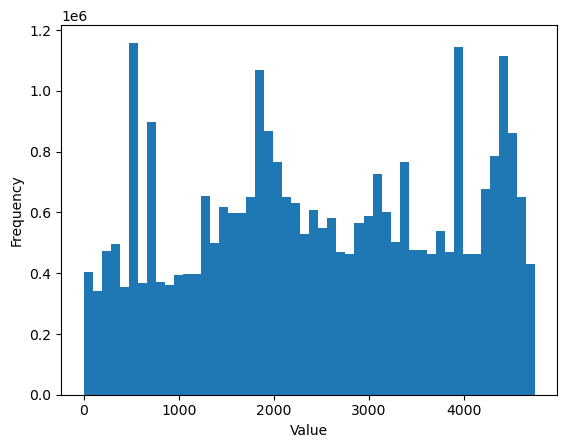

In [11]:
# Check the distribution of the data
plt.hist(superpixel_labels.flatten(), bins=50)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


## Classification

In [12]:
pre_alpha1 = np.load("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Pre_alpha_perimeter_data/pre_merged_alpha1_image_test_before_imputed.npy")
post_alpha1 = np.load("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Post_alpha_perimeter_data/post_merged_alpha_image_test_aligned_before_imputed.npy")
slope = np.load("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Slope/slope_aligned.npy")

In [13]:
print("pre_alpha1", pre_alpha1.shape)

pre_alpha1 (4921, 6093)


In [14]:
print("post_alpha1", post_alpha1.shape)

post_alpha1 (4921, 6093)


In [15]:
print("slope", slope.shape)

slope (4921, 6093)


In [16]:
np.seterr(divide='ignore', invalid='ignore')
#Extracting features
mean_log_ratio = get_superpixel_means_as_features(superpixel_labels, log_ratio)
median_pre_alpha1 = get_superpixel_medians_as_features(superpixel_labels, pre_alpha1)
median_post_alpha1 = get_superpixel_medians_as_features(superpixel_labels, post_alpha1)
diff_alpha1 = median_pre_alpha1 - median_post_alpha1
median_slope = get_superpixel_medians_as_features(superpixel_labels, slope)
# mean_slope = get_superpixel_means_as_features(superpixel_labels, slope)


In [17]:
unique_superpixel_labels = np.unique(superpixel_labels)
unique_superpixel_labels_reshape = unique_superpixel_labels.reshape(-1,1)


In [18]:
print(unique_superpixel_labels_reshape.shape)

(4744, 1)


In [19]:
# I need to check how to make a dataframe using these columns
fire_data = np.hstack([unique_superpixel_labels_reshape, diff_alpha1])

In [20]:
# # I need to check how to make a dataframe using these columns
# fire_data = np.hstack([unique_superpixel_labels_reshape,mean_log_ratio, diff_alpha1, median_slope])

In [21]:
import pandas as pd
# Create pandas dataframe with column names
df = pd.DataFrame(fire_data, columns=['superpixel_label', 'diff_alpha1'])
print(df)

      superpixel_label  diff_alpha1
0                  0.0          NaN
1                  1.0          NaN
2                  2.0          NaN
3                  3.0          NaN
4                  4.0          NaN
...                ...          ...
4739            4739.0          NaN
4740            4740.0          NaN
4741            4741.0          NaN
4742            4742.0          NaN
4743            4743.0          NaN

[4744 rows x 2 columns]


In [22]:
# Calculate the number of non-null values in each row
non_null_counts = df.count(axis=1)

# Get the total number of columns
num_columns = df.shape[1]

# Determine complete rows
complete_rows = df[non_null_counts == num_columns]

# Count the number of complete rows
num_complete_rows = len(complete_rows)
print(num_complete_rows)

1960


In [23]:
# retain only complete rows
df_cleaned = df.dropna()
print(len(df_cleaned))
#pd.set_option('display.max_rows',None)
print(df_cleaned)

1960
      superpixel_label  diff_alpha1
9                  9.0     4.473975
10                10.0     0.683176
11                11.0     5.293678
12                12.0     5.584470
13                13.0     3.420502
...                ...          ...
4680            4680.0    10.621142
4684            4684.0    -3.956638
4685            4685.0     4.800074
4702            4702.0    11.312406
4738            4738.0    13.223012

[1960 rows x 2 columns]


In [24]:
df_cleaned_for_model = df_cleaned.drop('superpixel_label', axis=1) # we don't want to use the superpixel label as a feature
print(df_cleaned_for_model)

      diff_alpha1
9        4.473975
10       0.683176
11       5.293678
12       5.584470
13       3.420502
...           ...
4680    10.621142
4684    -3.956638
4685     4.800074
4702    11.312406
4738    13.223012

[1960 rows x 1 columns]


Other Hyperparameter Values for K-means

In [25]:
from sklearn.cluster import KMeans

model = KMeans(
    n_clusters=4,
    init='k-means++',
    n_init=10,
    max_iter=300,
    tol=1e-4,
    algorithm='elkan',
    random_state=42
)
classes = get_superpixel_model_labels(df_cleaned_for_model, model)
classes = classes + 1
classes

array([1, 4, 1, ..., 1, 3, 3], dtype=int32)

In [26]:
print(np.unique(classes))

[1 2 3 4]


In [27]:
# print(len(classes))

print(df_cleaned.shape)

(1960, 2)


In [28]:
# Dr.Uma Code
model_output = superpixel_labels
# model_output = np.empty_like(superpixel_labels)
# model_output[:] = 0 # 0 indicates missing values since classes are numbered 1, 2, ...

for i in range(len(classes)):
    # print(i)
    # print(df_cleaned.iat[i,0])
    # print(classes[i])
    model_output[model_output==int(df_cleaned.iat[i,0])] = classes[i]
    # model_output = np.where(model_output == int(df_cleaned.iat[i,0]),classes[i],0) # logically this is correct
    # np.put(model_output,np.where(model_output==int(df_cleaned.iat[i,0])),classes[i])
    # model_output.replace(df_cleaned.iat[i,0],classes[i])
# print(superpixel_labels)
# print(model_output)

In [29]:
print(model_output)

[[   0    0    0 ...  105  105  105]
 [   0    0    0 ...  105  105  105]
 [   0    0    0 ...  105  105  105]
 ...
 [4365 4254 4254 ... 4453 4453 4453]
 [4365 4254 4254 ... 4453 4453 4453]
 [4365 4254 4254 ... 4453 4453 4453]]


In [30]:
#print(np.unique(model_output))
print(type(model_output))

<class 'numpy.ndarray'>


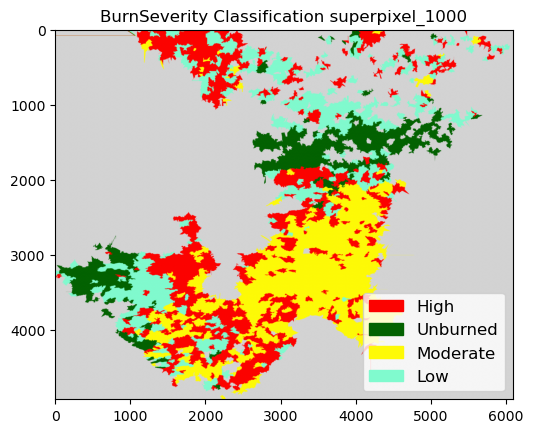

In [31]:
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
colors = ['lightgray'] * 10  # A default color for other values
colors[1] =  '#fc0200'
colors[2] = '#036201'
colors[3] = '#fefa07' 
colors[4] = '#80face'
# Unburned to Low: HEX #036201
# Low: #80face
# Moderate: #fefa07
# High: #fc0200
class_names = {
    1:  "High",
    2: "Unburned",
    3: "Moderate" ,
    4: "Low"
}

cmap = mcolors.ListedColormap(colors)

bounds = np.arange(len(colors) + 1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

legend_patches = [
    mpatches.Patch(color=colors[i], label=class_names[i]) for i in class_names
 ]

plt.imshow(model_output, cmap=cmap, norm=norm)
# plt.colorbar(ticks=np.arange(len(colors))) # Add a colorbar for reference
plt.title('BurnSeverity Classification superpixel_1000')
plt.legend(handles=legend_patches, loc='lower right', fontsize='large', frameon=True)
plt.show()

Confusion Matrix



Confusion Matrix (%):
Class 0:   6.79%   65.67%   11.74%   15.80%
Class 1:   4.53%   84.44%    5.94%    5.09%
Class 2:  33.76%   50.43%    7.95%    7.86%
Class 3:  32.02%   56.68%   10.33%    0.97%


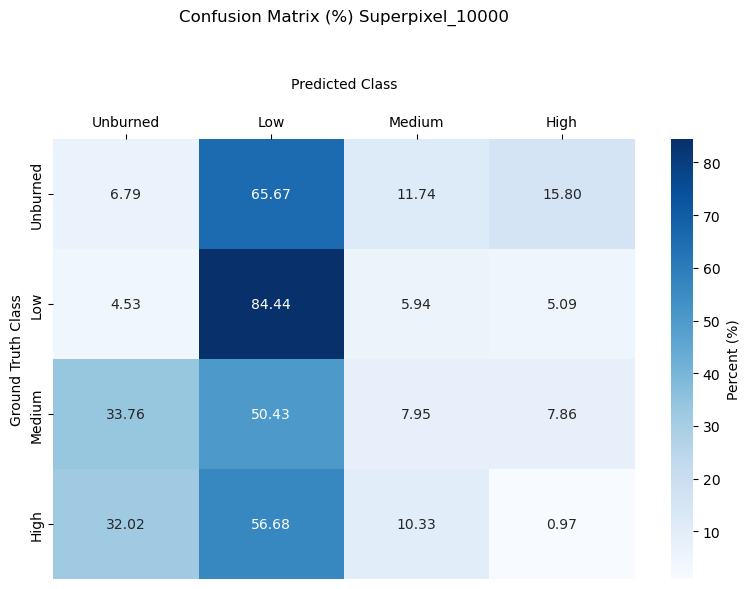


Overall Accuracy: 66.54%

Classification Report:
              precision    recall  f1-score   support

    Unburned       0.06      0.07      0.06     30436
         Low       0.83      0.84      0.84    285740
      Medium       0.15      0.08      0.10     46049
        High       0.00      0.01      0.01      9109

    accuracy                           0.67    371334
   macro avg       0.26      0.25      0.25    371334
weighted avg       0.66      0.67      0.66    371334



In [37]:
# === File Paths ===
ground_truth_path = "/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Confusion_matrix_dataset/ground_truth.png"
predicted_path =  "/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Confusion_matrix_dataset/BurnSeverity_Classification_Superpixel_10000.png"

# === Load Ground Truth and Predicted Images ===
gt_img = Image.open(ground_truth_path).convert("RGB")
pred_img = Image.open(predicted_path).convert("RGB")
pred_img = pred_img.resize(gt_img.size, Image.NEAREST)

# === Convert to Arrays ===
gt_array = np.array(gt_img)
pred_array = np.array(pred_img)

# === New Mapping: RGB → Class Index for Raster ===
color_to_class = {
    (3, 98, 1): 0,         # Unburned
    (128, 250, 206): 1,    # Low
    (254, 250, 7): 2,      # Medium
    (252, 2, 0): 3         # High
}

# === Function: Map RGB to Class ID Using Nearest Color ===
def rgb_to_class(pixel, color_map):
    distances = {cls: np.linalg.norm(np.array(pixel) - np.array(rgb)) for rgb, cls in color_map.items()}
    return min(distances, key=distances.get)

# === Convert to Class Index Rasters ===
gt_raster = np.apply_along_axis(rgb_to_class, 2, gt_array, color_map=color_to_class)
pred_raster = np.apply_along_axis(rgb_to_class, 2, pred_array, color_map=color_to_class)

# === Flatten for Evaluation ===
gt_labels = gt_raster.flatten()
pred_labels = pred_raster.flatten()

# === Compute Confusion Matrix ===
conf_mat = confusion_matrix(gt_labels, pred_labels)

# === Normalize to Percentages ===
conf_mat_percent = conf_mat.astype(np.float64)
conf_mat_percent = conf_mat_percent / conf_mat_percent.sum(axis=1, keepdims=True) * 100

# === Print Normalized Confusion Matrix ===
print("Confusion Matrix (%):")
for i, row in enumerate(conf_mat_percent):
    print(f"Class {i}: " + "  ".join(f"{val:6.2f}%" for val in row))

# === Plot Heatmap ===
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_mat_percent, annot=True, fmt=".2f", cmap="Blues",
                 xticklabels=["Unburned", "Low", "Medium", "High"],
                 yticklabels=["Unburned", "Low", "Medium", "High"],
                 cbar_kws={"label": "Percent (%)"})
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xlabel("Predicted Class", labelpad=20)
plt.ylabel("Ground Truth Class")
plt.title("Confusion Matrix (%) Superpixel_10000", pad=40)
plt.tight_layout()
plt.show()

# === Compute and Print Accuracy ===
accuracy = accuracy_score(gt_labels, pred_labels)
print(f"\nOverall Accuracy: {accuracy * 100:.2f}%")

# === Classification Report ===
class_names = ["Unburned", "Low", "Medium", "High"]
report = classification_report(gt_labels, pred_labels, target_names=class_names, digits=2)
print("\nClassification Report:")
print(report)


Confusion Matrix (%):
Class 0:  13.41%   60.96%    8.34%   17.29%
Class 1:   5.16%   82.00%    5.78%    7.06%
Class 2:   8.43%   26.93%   35.12%   29.52%
Class 3:   6.05%    9.33%   35.42%   49.20%


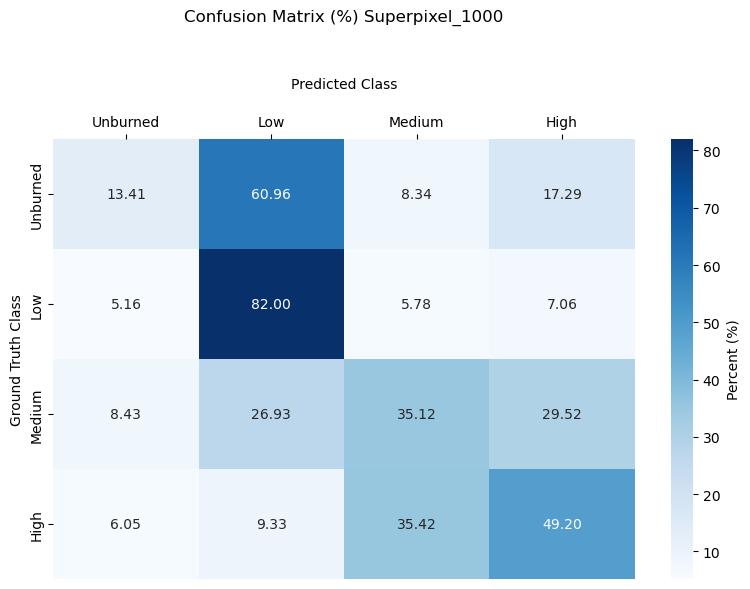


Overall Accuracy: 69.76%

Classification Report:
              precision    recall  f1-score   support

    Unburned       0.18      0.13      0.15     30436
         Low       0.88      0.82      0.85    285740
      Medium       0.42      0.35      0.38     46049
        High       0.10      0.49      0.17      9109

    accuracy                           0.70    371334
   macro avg       0.39      0.45      0.39    371334
weighted avg       0.75      0.70      0.72    371334



In [38]:
# === File Paths ===
ground_truth_path = "/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Confusion_matrix_dataset/ground_truth.png"
predicted_path =  "/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Confusion_matrix_dataset/BurnSeverity_Classification_Superpixel_1000.png"
# === Load Ground Truth and Predicted Images ===
gt_img = Image.open(ground_truth_path).convert("RGB")
pred_img = Image.open(predicted_path).convert("RGB")
pred_img = pred_img.resize(gt_img.size, Image.NEAREST)

# === Convert to Arrays ===
gt_array = np.array(gt_img)
pred_array = np.array(pred_img)

# === New Mapping: RGB → Class Index for Raster ===
color_to_class = {
    (3, 98, 1): 0,         # Unburned
    (128, 250, 206): 1,    # Low
    (254, 250, 7): 2,      # Medium
    (252, 2, 0): 3         # High
}

# === Function: Map RGB to Class ID Using Nearest Color ===
def rgb_to_class(pixel, color_map):
    distances = {cls: np.linalg.norm(np.array(pixel) - np.array(rgb)) for rgb, cls in color_map.items()}
    return min(distances, key=distances.get)

# === Convert to Class Index Rasters ===
gt_raster = np.apply_along_axis(rgb_to_class, 2, gt_array, color_map=color_to_class)
pred_raster = np.apply_along_axis(rgb_to_class, 2, pred_array, color_map=color_to_class)

# === Flatten for Evaluation ===
gt_labels = gt_raster.flatten()
pred_labels = pred_raster.flatten()

# === Compute Confusion Matrix ===
conf_mat = confusion_matrix(gt_labels, pred_labels)

# === Normalize to Percentages ===
conf_mat_percent = conf_mat.astype(np.float64)
conf_mat_percent = conf_mat_percent / conf_mat_percent.sum(axis=1, keepdims=True) * 100

# === Print Normalized Confusion Matrix ===
print("Confusion Matrix (%):")
for i, row in enumerate(conf_mat_percent):
    print(f"Class {i}: " + "  ".join(f"{val:6.2f}%" for val in row))

# === Plot Heatmap ===
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_mat_percent, annot=True, fmt=".2f", cmap="Blues",
                 xticklabels=["Unburned", "Low", "Medium", "High"],
                 yticklabels=["Unburned", "Low", "Medium", "High"],
                 cbar_kws={"label": "Percent (%)"})
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xlabel("Predicted Class", labelpad=20)
plt.ylabel("Ground Truth Class")
plt.title("Confusion Matrix (%) Superpixel_1000", pad=40)
plt.tight_layout()
plt.show()

# === Compute and Print Accuracy ===
accuracy = accuracy_score(gt_labels, pred_labels)
print(f"\nOverall Accuracy: {accuracy * 100:.2f}%")

# === Classification Report ===
class_names = ["Unburned", "Low", "Medium", "High"]
report = classification_report(gt_labels, pred_labels, target_names=class_names, digits=2)
print("\nClassification Report:")
print(report)


Confusion Matrix (%):
Class 0:  14.28%   63.02%    7.00%   15.70%
Class 1:   6.37%   81.58%    5.34%    6.71%
Class 2:   8.86%   29.01%   30.85%   31.28%
Class 3:   8.17%   11.53%   31.13%   49.17%


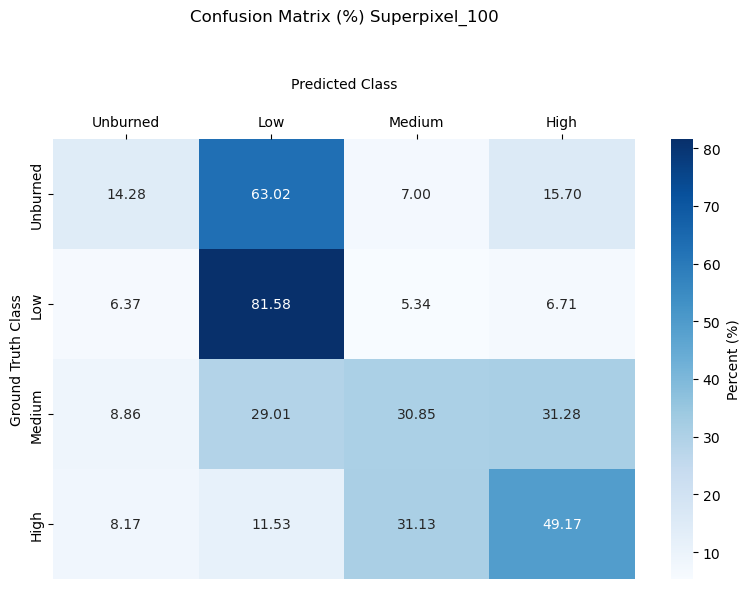


Overall Accuracy: 68.98%

Classification Report:
              precision    recall  f1-score   support

    Unburned       0.16      0.14      0.15     30436
         Low       0.87      0.82      0.84    285740
      Medium       0.41      0.31      0.35     46049
        High       0.10      0.49      0.17      9109

    accuracy                           0.69    371334
   macro avg       0.39      0.44      0.38    371334
weighted avg       0.74      0.69      0.71    371334



In [39]:
# === File Paths ===
ground_truth_path = "/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Confusion_matrix_dataset/ground_truth.png"
predicted_path =  "/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Confusion_matrix_dataset/BurnSeverity_Classification_Superpixel_100.png"

# === Load Ground Truth and Predicted Images ===
gt_img = Image.open(ground_truth_path).convert("RGB")
pred_img = Image.open(predicted_path).convert("RGB")
pred_img = pred_img.resize(gt_img.size, Image.NEAREST)

# === Convert to Arrays ===
gt_array = np.array(gt_img)
pred_array = np.array(pred_img)

# === New Mapping: RGB → Class Index for Raster ===
color_to_class = {
    (3, 98, 1): 0,         # Unburned
    (128, 250, 206): 1,    # Low
    (254, 250, 7): 2,      # Medium
    (252, 2, 0): 3         # High
}

# === Function: Map RGB to Class ID Using Nearest Color ===
def rgb_to_class(pixel, color_map):
    distances = {cls: np.linalg.norm(np.array(pixel) - np.array(rgb)) for rgb, cls in color_map.items()}
    return min(distances, key=distances.get)

# === Convert to Class Index Rasters ===
gt_raster = np.apply_along_axis(rgb_to_class, 2, gt_array, color_map=color_to_class)
pred_raster = np.apply_along_axis(rgb_to_class, 2, pred_array, color_map=color_to_class)

# === Flatten for Evaluation ===
gt_labels = gt_raster.flatten()
pred_labels = pred_raster.flatten()

# === Compute Confusion Matrix ===
conf_mat = confusion_matrix(gt_labels, pred_labels)

# === Normalize to Percentages ===
conf_mat_percent = conf_mat.astype(np.float64)
conf_mat_percent = conf_mat_percent / conf_mat_percent.sum(axis=1, keepdims=True) * 100

# === Print Normalized Confusion Matrix ===
print("Confusion Matrix (%):")
for i, row in enumerate(conf_mat_percent):
    print(f"Class {i}: " + "  ".join(f"{val:6.2f}%" for val in row))

# === Plot Heatmap ===
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_mat_percent, annot=True, fmt=".2f", cmap="Blues",
                 xticklabels=["Unburned", "Low", "Medium", "High"],
                 yticklabels=["Unburned", "Low", "Medium", "High"],
                 cbar_kws={"label": "Percent (%)"})
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xlabel("Predicted Class", labelpad=20)
plt.ylabel("Ground Truth Class")
plt.title("Confusion Matrix (%) Superpixel_100", pad=40)
plt.tight_layout()
plt.show()

# === Compute and Print Accuracy ===
accuracy = accuracy_score(gt_labels, pred_labels)
print(f"\nOverall Accuracy: {accuracy * 100:.2f}%")

# === Classification Report ===
class_names = ["Unburned", "Low", "Medium", "High"]
report = classification_report(gt_labels, pred_labels, target_names=class_names, digits=2)
print("\nClassification Report:")
print(report)


Confusion Matrix (%):
Class 0:  15.94%   62.96%    6.34%   14.76%
Class 1:   6.39%   81.84%    5.13%    6.65%
Class 2:   9.72%   29.22%   28.46%   32.60%
Class 3:  10.03%   11.64%   28.59%   49.74%


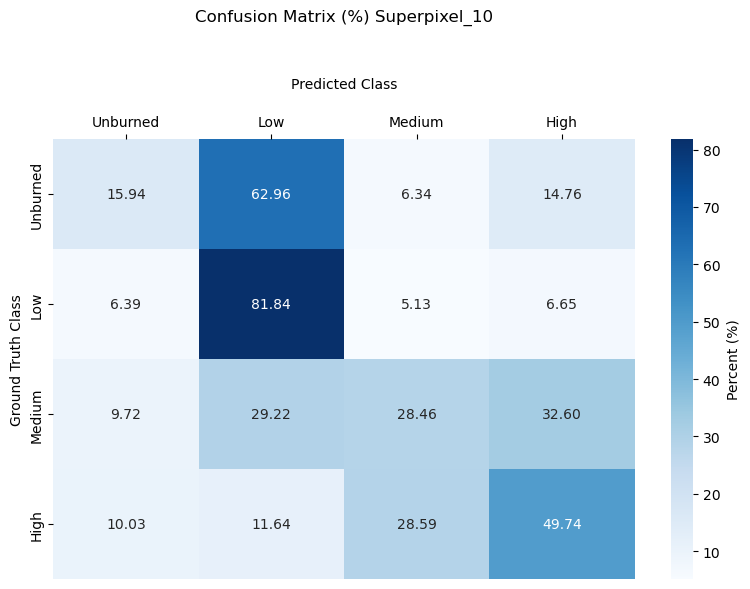


Overall Accuracy: 69.03%

Classification Report:
              precision    recall  f1-score   support

    Unburned       0.17      0.16      0.16     30436
         Low       0.87      0.82      0.85    285740
      Medium       0.41      0.28      0.33     46049
        High       0.11      0.50      0.17      9109

    accuracy                           0.69    371334
   macro avg       0.39      0.44      0.38    371334
weighted avg       0.74      0.69      0.71    371334



In [40]:
# === File Paths ===
ground_truth_path = "/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Confusion_matrix_dataset/ground_truth.png"
predicted_path =  "/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Confusion_matrix_dataset/BurnSeverity_Classification_Superpixel_10.png"

# === Load Ground Truth and Predicted Images ===
gt_img = Image.open(ground_truth_path).convert("RGB")
pred_img = Image.open(predicted_path).convert("RGB")
pred_img = pred_img.resize(gt_img.size, Image.NEAREST)

# === Convert to Arrays ===
gt_array = np.array(gt_img)
pred_array = np.array(pred_img)

# === New Mapping: RGB → Class Index for Raster ===
color_to_class = {
    (3, 98, 1): 0,         # Unburned
    (128, 250, 206): 1,    # Low
    (254, 250, 7): 2,      # Medium
    (252, 2, 0): 3         # High
}

# === Function: Map RGB to Class ID Using Nearest Color ===
def rgb_to_class(pixel, color_map):
    distances = {cls: np.linalg.norm(np.array(pixel) - np.array(rgb)) for rgb, cls in color_map.items()}
    return min(distances, key=distances.get)

# === Convert to Class Index Rasters ===
gt_raster = np.apply_along_axis(rgb_to_class, 2, gt_array, color_map=color_to_class)
pred_raster = np.apply_along_axis(rgb_to_class, 2, pred_array, color_map=color_to_class)

# === Flatten for Evaluation ===
gt_labels = gt_raster.flatten()
pred_labels = pred_raster.flatten()

# === Compute Confusion Matrix ===
conf_mat = confusion_matrix(gt_labels, pred_labels)

# === Normalize to Percentages ===
conf_mat_percent = conf_mat.astype(np.float64)
conf_mat_percent = conf_mat_percent / conf_mat_percent.sum(axis=1, keepdims=True) * 100

# === Print Normalized Confusion Matrix ===
print("Confusion Matrix (%):")
for i, row in enumerate(conf_mat_percent):
    print(f"Class {i}: " + "  ".join(f"{val:6.2f}%" for val in row))

# === Plot Heatmap ===
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_mat_percent, annot=True, fmt=".2f", cmap="Blues",
                 xticklabels=["Unburned", "Low", "Medium", "High"],
                 yticklabels=["Unburned", "Low", "Medium", "High"],
                 cbar_kws={"label": "Percent (%)"})
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xlabel("Predicted Class", labelpad=20)
plt.ylabel("Ground Truth Class")
plt.title("Confusion Matrix (%) Superpixel_10", pad=40)
plt.tight_layout()
plt.show()

# === Compute and Print Accuracy ===
accuracy = accuracy_score(gt_labels, pred_labels)
print(f"\nOverall Accuracy: {accuracy * 100:.2f}%")

# === Classification Report ===
class_names = ["Unburned", "Low", "Medium", "High"]
report = classification_report(gt_labels, pred_labels, target_names=class_names, digits=2)
print("\nClassification Report:")
print(report)


Confusion Matrix (%):
Class 0:  13.86%   61.06%    6.99%   18.09%
Class 1:   5.31%   81.39%    5.34%    7.96%
Class 2:   7.61%   28.83%   31.51%   32.04%
Class 3:   5.38%   11.80%   32.11%   50.71%


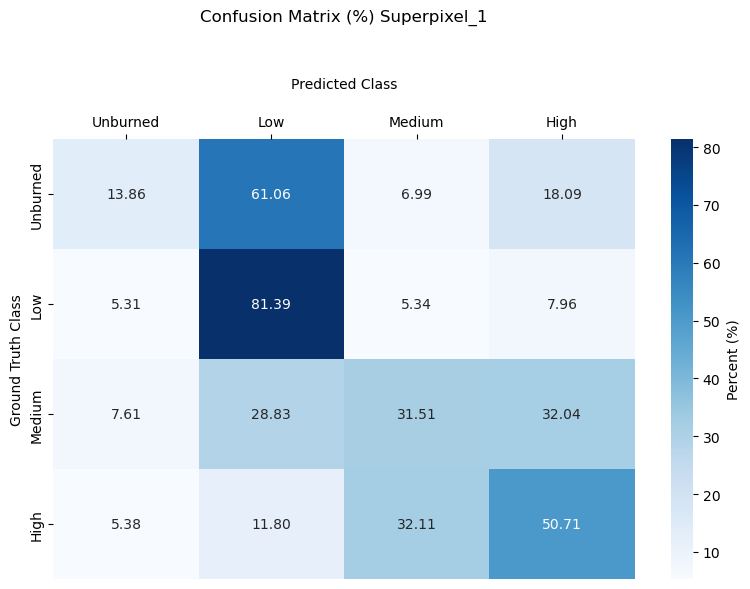


Overall Accuracy: 68.92%

Classification Report:
              precision    recall  f1-score   support

    Unburned       0.18      0.14      0.16     30436
         Low       0.88      0.81      0.84    285740
      Medium       0.42      0.32      0.36     46049
        High       0.10      0.51      0.16      9109

    accuracy                           0.69    371334
   macro avg       0.39      0.44      0.38    371334
weighted avg       0.74      0.69      0.71    371334



In [41]:

# === File Paths ===
ground_truth_path = "/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Confusion_matrix_dataset/ground_truth.png"
predicted_path =  "/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Confusion_matrix_dataset/BurnSeverity_Classification_Superpixel_1.png"

# === Load Ground Truth and Predicted Images ===
gt_img = Image.open(ground_truth_path).convert("RGB")
pred_img = Image.open(predicted_path).convert("RGB")
pred_img = pred_img.resize(gt_img.size, Image.NEAREST)

# === Convert to Arrays ===
gt_array = np.array(gt_img)
pred_array = np.array(pred_img)

# === New Mapping: RGB → Class Index for Raster ===
color_to_class = {
    (3, 98, 1): 0,         # Unburned
    (128, 250, 206): 1,    # Low
    (254, 250, 7): 2,      # Medium
    (252, 2, 0): 3         # High
}

# === Function: Map RGB to Class ID Using Nearest Color ===
def rgb_to_class(pixel, color_map):
    distances = {cls: np.linalg.norm(np.array(pixel) - np.array(rgb)) for rgb, cls in color_map.items()}
    return min(distances, key=distances.get)

# === Convert to Class Index Rasters ===
gt_raster = np.apply_along_axis(rgb_to_class, 2, gt_array, color_map=color_to_class)
pred_raster = np.apply_along_axis(rgb_to_class, 2, pred_array, color_map=color_to_class)

# === Flatten for Evaluation ===
gt_labels = gt_raster.flatten()
pred_labels = pred_raster.flatten()

# === Compute Confusion Matrix ===
conf_mat = confusion_matrix(gt_labels, pred_labels)

# === Normalize to Percentages ===
conf_mat_percent = conf_mat.astype(np.float64)
conf_mat_percent = conf_mat_percent / conf_mat_percent.sum(axis=1, keepdims=True) * 100

# === Print Normalized Confusion Matrix ===
print("Confusion Matrix (%):")
for i, row in enumerate(conf_mat_percent):
    print(f"Class {i}: " + "  ".join(f"{val:6.2f}%" for val in row))

# === Plot Heatmap ===
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_mat_percent, annot=True, fmt=".2f", cmap="Blues",
                 xticklabels=["Unburned", "Low", "Medium", "High"],
                 yticklabels=["Unburned", "Low", "Medium", "High"],
                 cbar_kws={"label": "Percent (%)"})
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xlabel("Predicted Class", labelpad=20)
plt.ylabel("Ground Truth Class")
plt.title("Confusion Matrix (%) Superpixel_1", pad=40)
plt.tight_layout()
plt.show()

# === Compute and Print Accuracy ===
accuracy = accuracy_score(gt_labels, pred_labels)
print(f"\nOverall Accuracy: {accuracy * 100:.2f}%")

# === Classification Report ===
class_names = ["Unburned", "Low", "Medium", "High"]
report = classification_report(gt_labels, pred_labels, target_names=class_names, digits=2)
print("\nClassification Report:")
print(report)
